<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sport-Vouchers-Program-Analysis" data-toc-modified-id="Sport-Vouchers-Program-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sport Vouchers Program Analysis</a></span><ul class="toc-item"><li><span><a href="#Description-of-voucher-data:" data-toc-modified-id="Description-of-voucher-data:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description of voucher data:</a></span></li><li><span><a href="#Description-of-seifa-data:" data-toc-modified-id="Description-of-seifa-data:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Description of seifa data:</a></span></li><li><span><a href="#For-later-visualisation-purposes,-LGA-map-data-will-be-read-into-the-notebook" data-toc-modified-id="For-later-visualisation-purposes,-LGA-map-data-will-be-read-into-the-notebook-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>For later visualisation purposes, LGA map data will be read into the notebook</a></span></li></ul></li><li><span><a href="#Describe-the-distribution-of-vouchers-by:-LGA,-Sport---which-regions/sports-stand-out?" data-toc-modified-id="Describe-the-distribution-of-vouchers-by:-LGA,-Sport---which-regions/sports-stand-out?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?</a></span><ul class="toc-item"><li><span><a href="#By-LGA" data-toc-modified-id="By-LGA-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>By LGA</a></span></li><li><span><a href="#Findings-of-LGA-analysis:" data-toc-modified-id="Findings-of-LGA-analysis:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Findings of LGA analysis:</a></span></li><li><span><a href="#By-Sports" data-toc-modified-id="By-Sports-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>By Sports</a></span></li><li><span><a href="#Findings-of-Sports-analysis:" data-toc-modified-id="Findings-of-Sports-analysis:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Findings of Sports analysis:</a></span></li></ul></li><li><span><a href="#Are-some-sports-more-popular-in-different-parts-of-the-state?" data-toc-modified-id="Are-some-sports-more-popular-in-different-parts-of-the-state?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Are some sports more popular in different parts of the state?</a></span><ul class="toc-item"><li><span><a href="#Findings:" data-toc-modified-id="Findings:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Findings:</a></span></li><li><span><a href="#Plot-Voucher-distribution-on-Map" data-toc-modified-id="Plot-Voucher-distribution-on-Map-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot Voucher distribution on Map</a></span></li></ul></li><li><span><a href="#Are-any-LGAs-over/under-represented-in-their-use-of-vouchers?" data-toc-modified-id="Are-any-LGAs-over/under-represented-in-their-use-of-vouchers?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Are any LGAs over/under represented in their use of vouchers?</a></span></li><li><span><a href="#calculate-mean-value-of-voucher-amount-and-subtract-from-value-to-show-over/under" data-toc-modified-id="calculate-mean-value-of-voucher-amount-and-subtract-from-value-to-show-over/under-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>calculate mean value of voucher amount and subtract from value to show over/under</a></span></li><li><span><a href="#double-check-missing-values" data-toc-modified-id="double-check-missing-values-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>double check missing values</a></span><ul class="toc-item"><li><span><a href="#Findings-of-LGA-analysis:" data-toc-modified-id="Findings-of-LGA-analysis:-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Findings of LGA analysis:</a></span></li></ul></li><li><span><a href="#Is-there-a-relationship-between-any-of-the-SEIFA-measures-and-voucher-use-in-an-LGA?" data-toc-modified-id="Is-there-a-relationship-between-any-of-the-SEIFA-measures-and-voucher-use-in-an-LGA?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Is there a relationship between any of the SEIFA measures and voucher use in an LGA?</a></span><ul class="toc-item"><li><span><a href="#Conduct-univariate-analysis-of-variables" data-toc-modified-id="Conduct-univariate-analysis-of-variables-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Conduct univariate analysis of variables</a></span></li><li><span><a href="#ATSI" data-toc-modified-id="ATSI-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>ATSI</a></span></li><li><span><a href="#CALD" data-toc-modified-id="CALD-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>CALD</a></span></li><li><span><a href="#Sex" data-toc-modified-id="Sex-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Sex</a></span></li><li><span><a href="#IEO" data-toc-modified-id="IEO-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>IEO</a></span></li><li><span><a href="#IER" data-toc-modified-id="IER-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>IER</a></span></li><li><span><a href="#IRSAD" data-toc-modified-id="IRSAD-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>IRSAD</a></span></li><li><span><a href="#IRSD" data-toc-modified-id="IRSD-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span>IRSD</a></span></li></ul></li><li><span><a href="#Challenge---Queensland" data-toc-modified-id="Challenge---Queensland-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Challenge - Queensland</a></span></li></ul></div>

# Sport Vouchers Program Analysis

The goal of this Portfolio task is to explore data from the Federal Government Sport Vouchers program - this is a
program that provides up to two $100 vouchers for kids to participate in organised sport. Here's the [NSW Active Kids page](https://www.service.nsw.gov.au/transaction/apply-active-kids-voucher), there are similar schemes in other states - this data is from South Australia.

This is an exercise in exploring data and communicating the insights you can gain from it.  The source data comes
from the `data.gov.au` website and provides details of all Sport Vouchers that have been redeemed since February  in SA 2015 as part of the Sport Voucher program:  [Sports Vouchers Data](https://data.gov.au/dataset/ds-sa-14daba50-04ff-46c6-8468-9fa593b9f100/details).  This download is provided for you as `sportsvouchersclaimed.csv`.

To augment this data you can also make use of [ABS SEIFA data by LGA](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ABS_SEIFA_LGA#) which shows a few measures of Socioeconomic Advantage and Disadvantage for every Local Government Area. This data is provided for you as `ABS_SEIFA_LGA.csv`. This could enable you to answer questions about whether the voucher program is used equally by parents in low, middle and high socioeconomic areas.   You might be interested in this if you were concerned that this kind of program might just benifit parents who are already advantaged (they might already be paying for sport so this program wouldn't be helping much).

Questions:
* Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out? 
* Are some sports more popular in different parts of the state?
* Are any LGAs over/under represented in their use of vouchers?
* Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

A challenge in this task is to display a useful summary of the data given that there are a large number of LGAs and sports involved.  Try to avoid long lists and large tables. Think about what plots and tables communicate the main points of your findings. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [2]:
# read the sports vouchers data
sa_vouchers = pd.read_csv("files/sportsvouchersclaimed.csv")
sa_vouchers.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015


In [3]:
# check distribution of recurring redemption vs first joiners

In [4]:
# check distribution of aboriginal background vs non-aboriginal background

In [5]:
# check distribution of cultural heritage

In [6]:
# check distribution of genders

The SEIFA data includes row for each Local Government Area (LGA) but the names of the LGAs have a letter or letters in brackets after the name.  To allow us to match this up with the voucher data we remove this and convert to uppercase. 

For each LGA the data includes a number of measures all of which could be useful in your exploration.  

In [7]:
# read the SEIFA data, create an LGA column by removing the letters in brackets and converting to uppercase
seifa = pd.read_csv('files/ABS_SEIFA_LGA.csv')
lga = seifa["Local Government Areas - 2011"].str.replace(' \([ACSRCDMT]+\)', '', regex=True).str.upper()
seifa['LGA'] = lga
seifa.head()

,LGA_2011,Local Government Areas - 2011,INDEX_TYPE,Index Type,MEASURE,Measure,Value,LGA
0,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,967,ALBURY
1,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MINS,Minimum score for SA1s in area,628,ALBURY
2,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,MAXS,Maximum score for SA1s in area,1169,ALBURY
3,10050,Albury (C),IRSAD,Index of Relative Socio-economic Advantage and...,URP,Usual resident population,47851,ALBURY
4,10110,Armidale Dumaresq (A),IRSAD,Index of Relative Socio-economic Advantage and...,SCORE,Score,985,ARMIDALE DUMARESQ


Since there are many rows per LGA we need to use `pivot_table` to create a new data frame with one row per LGA. Here
is an example of doing this to create a table with the different SCORE measures and the population (URP) field. 

In [8]:
LGA_scores = seifa[seifa.MEASURE == 'SCORE'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores.head()
LGA_pop = seifa[seifa.MEASURE == 'URP'].pivot_table(index="LGA", columns=["INDEX_TYPE"], values="Value")
LGA_scores['Population'] = LGA_pop.IEO
LGA_scores.head()

INDEX_TYPE,IEO,IER,IRSAD,IRSD,Population
LGA,,,,,
ADELAIDE,874.0,874.0,1036.0,1013.0,19606.0
ADELAIDE HILLS,1083.0,1083.0,1077.0,1081.0,38601.0
ALBANY,999.0,999.0,977.0,987.0,33614.0
ALBURY,964.0,964.0,967.0,979.0,47851.0
ALEXANDRINA,1000.0,1000.0,969.0,987.0,23693.0


This data frame can then be joined with the vouchers data fram to create one master data frame containing both the voucher data and the SEIFA measures.

In [9]:
sa_vouchers_scores = sa_vouchers.join(LGA_scores, on='Participant_LGA')
sa_vouchers_scores.head()

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,26/6/15 1:19,2015,996.0,996.0,975.0,993.0,159517.0
1,1000002,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Male,50,Flagstaff Hill Football Club,Australian Rules,ONKAPARINGA,FISHER,29/6/16 23:55,2016,996.0,996.0,975.0,993.0,159517.0
2,1000004,ABERFOYLE PARK,Not Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,21/4/16 3:37,2016,996.0,996.0,975.0,993.0,159517.0
3,1000004,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Hub Gymnastics Club,Gymnastics,ONKAPARINGA,FISHER,30/3/17 0:47,2017,996.0,996.0,975.0,993.0,159517.0
4,1000005,ABERFOYLE PARK,Registered Previously,Not ATSI,Not CALD,Female,50,Blackwood Community Recreation Association,Gymnastics,ONKAPARINGA,FISHER,20/7/15 2:50,2015,996.0,996.0,975.0,993.0,159517.0


In [10]:
sa_vouchers_scores[sa_vouchers_scores["Participant_LGA"].str.contains('ADELAIDE PLAINS') == True]

,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,Participant_CALD_Indicator,Participant_Sex,Voucher_Value,Club_Name,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
6954,1006955,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,30/3/17 0:46,2017,NaN,NaN,NaN,NaN,NaN
6955,1006956,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Mallala Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,14/9/15 5:20,2015,NaN,NaN,NaN,NaN,NaN
6956,1006957,BARABBA,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/3/17 0:37,2017,NaN,NaN,NaN,NaN,NaN
6957,1006960,BARABBA,Not Registered Previously,Not ATSI,Not CALD,Male,50,Hamley Bridge Football Club,Australian Rules,ADELAIDE PLAINS,GOYDER,28/8/15 2:28,2015,NaN,NaN,NaN,NaN,NaN
6958,1006960,BARABBA,Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123703,1123704,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,17/6/16 1:03,2016,NaN,NaN,NaN,NaN,NaN
123704,1123705,WINDSOR,Registered Previously,Not ATSI,Not CALD,Female,50,Mallala Netball Club,Netball,ADELAIDE PLAINS,GOYDER,30/5/17 7:58,2017,NaN,NaN,NaN,NaN,NaN
123705,1123706,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Female,50,Long Plains Netball Club,Netball,ADELAIDE PLAINS,GOYDER,25/2/16 2:23,2015,NaN,NaN,NaN,NaN,NaN
123706,1123707,WINDSOR,Not Registered Previously,Not ATSI,Not CALD,Male,50,S.A.N.F.L,Australian Rules,ADELAIDE PLAINS,GOYDER,28/4/17 5:04,2017,NaN,NaN,NaN,NaN,NaN


## Description of voucher data:

- __Participant_ATSI_Indicator:__ Categorises the participant as identifying with aboriginal or Torres Strait Island heritage (ATSI), or not (Not ATSI)
- __Participant_CALD_Indicator:__ Categorises the participant as identifying with a non-Australian cultural background (CALD) or not (Not CALD) 
- __Voucher_Sport:__ Description of the activity undertaken using a sport voucher

## Description of seifa data:

__Low score indicates most disadvantaged.__

- __IRSAD:__ The Index of Relative Socio-economic Advantage and Disadvantage (IRSAD) summarises information about the economic and social conditions of people and households within an area, including both relative advantage and disadvantage measures.
- __IRSD:__ The Index of Relative Socio-economic Disadvantage (IRSD) is a general socio-economic index that summarises a range of information about the economic and social conditions of people and households within an area.
- __IER:__ The Index of Economic Resources (IER) focuses on the financial aspects of relative socio-economic advantage and disadvantage, by summarising variables related to income and wealth. This index excludes education and occupation variables because they are not direct measures of economic resources. It also misses some assets such as savings or equities which, although relevant, could not be included because this information was not collected in the 2011 Census.
- __IEO:__ The Index of Education and Occupation (IEO) is designed to reflect the educational and occupational level of communities.

## For later visualisation purposes, LGA map data will be read into the notebook

In [11]:
# get url of geojson file
sa_data = "files/LGA_GDA2020.geojson"

# read data in
sa_lga_gdf = gpd.read_file(sa_data)
sa_lga_gdf.head(10)

,lgatype,abbname,lga,shape_Length,shape_Area,geometry
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178..."
1,CC,BURNSIDE,CITY OF BURNSIDE,0.329033,0.002711,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746..."
2,CC,MOUNT GAMBIER,CITY OF MOUNT GAMBIER,0.271197,0.003480,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662..."
3,CC,PORT ADELAIDE ENFIELD,CITY OF PORT ADELAIDE ENFIELD,0.766721,0.009304,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967..."
4,CC,PORT AUGUSTA,PORT AUGUSTA CITY COUNCIL,2.837862,0.123108,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448..."
5,CC,PORT LINCOLN,CITY OF PORT LINCOLN,0.348251,0.003177,"MULTIPOLYGON (((135.86922 -34.72065, 135.86919..."
6,None,APY,ANANGU PITJANTJATJARA YANKUNYTJATJARA,15.133027,9.304640,"MULTIPOLYGON (((133.11182 -25.99856, 133.10877..."
7,CC,CAMPBELLTOWN,CAMPBELLTOWN CITY COUNCIL,0.270780,0.002400,"MULTIPOLYGON (((138.71422 -34.86066, 138.71436..."
8,CC,MITCHAM,CITY OF MITCHAM,0.445905,0.007472,"MULTIPOLYGON (((138.64728 -34.96504, 138.64800..."
9,CC,PROSPECT,CITY OF PROSPECT,0.122863,0.000770,"MULTIPOLYGON (((138.60184 -34.86996, 138.60185..."


In [12]:
sa_lga_gdf.tail(10)

,lgatype,abbname,lga,shape_Length,shape_Area,geometry
64,MC,PLAYFORD,CITY OF PLAYFORD,1.508096,0.035247,"MULTIPOLYGON (((138.67086 -34.61590, 138.67110..."
65,MC,PORT PIRIE,PORT PIRIE REGIONAL COUNCIL,2.563453,0.190227,"MULTIPOLYGON (((138.16422 -33.10628, 138.16488..."
66,MC,ROXBY DOWNS,MUNICIPAL COUNCIL OF ROXBY DOWNS,0.442288,0.010390,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787..."
67,MC,TEA TREE GULLY,CITY OF TEA TREE GULLY,0.616511,0.009390,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396..."
68,MC,WEST TORRENS,CITY OF WEST TORRENS,0.283411,0.003657,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685..."
69,RC,MURRAY BRIDGE,THE RURAL CITY OF MURRAY BRIDGE,2.508383,0.180811,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040..."
70,RC,WAKEFIELD,WAKEFIELD REGIONAL COUNCIL,3.258034,0.343638,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297..."
71,WD,UIA RIVERLAND,UIA RIVERLAND,1.524901,0.031467,"MULTIPOLYGON (((140.72829 -34.10345, 140.72841..."
72,None,MT,MARALINGA TJARUTJA,16.434194,9.832557,"MULTIPOLYGON (((132.99386 -28.11736, 132.99888..."
73,None,PUA,PASTORAL UNINCORPORATED AREA,53.200633,57.730720,"MULTIPOLYGON (((140.99940 -25.99638, 140.99944..."


In [13]:
# check missing values
sa_lga_gdf.isnull().any()

lgatype          True
abbname         False
lga             False
shape_Length    False
shape_Area      False
geometry        False
dtype: bool

In [14]:
# merge with sa_voucher data
map_df = pd.merge(sa_lga_gdf, sa_vouchers_scores, how='outer', left_on = 'abbname', right_on = 'Participant_LGA')
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127528,NaN,NaN,NaN,NaN,NaN,None,1127488.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,16/12/15 2:24,2015.0,966.0,966.0,935.0,949.0,5520.0
127529,NaN,NaN,NaN,NaN,NaN,None,1127490.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,24/1/17 0:15,2016.0,966.0,966.0,935.0,949.0,5520.0
127530,NaN,NaN,NaN,NaN,NaN,None,1127490.0,YUMALI,Registered Previously,Not ATSI,...,Swimming,THE COORONG,HAMMOND,16/12/15 2:24,2015.0,966.0,966.0,935.0,949.0,5520.0
127531,NaN,NaN,NaN,NaN,NaN,None,1127491.0,YUMALI,Registered Previously,Not ATSI,...,Australian Rules,THE COORONG,HAMMOND,28/4/15 0:05,2015.0,966.0,966.0,935.0,949.0,5520.0


In [15]:
# check for missing geometry 
map_df[map_df['geometry'] == None]['Participant_LGA'].unique()

array(['NO LGA', 'THE COORONG'], dtype=object)

In [16]:
# check for existance of names in geo data
sa_lga_gdf[sa_lga_gdf["abbname"].str.contains('LGA', 'COORONG')]

,lgatype,abbname,lga,shape_Length,shape_Area,geometry


In [17]:
# display unique lga names in geodata
sa_lga_gdf["abbname"].unique() 

array(['ADELAIDE', 'BURNSIDE', 'MOUNT GAMBIER', 'PORT ADELAIDE ENFIELD',
       'PORT AUGUSTA', 'PORT LINCOLN', 'APY', 'CAMPBELLTOWN', 'MITCHAM',
       'PROSPECT', 'SALISBURY', 'UNLEY', 'WHYALLA', 'WALKERVILLE',
       'ADELAIDE HILLS', 'ADELAIDE PLAINS', 'GAWLER', 'VICTOR HARBOR',
       'ALEXANDRINA', 'BAROSSA', 'BARUNGA WEST', 'BERRI BARMERA',
       'CEDUNA', 'CLARE AND GILBERT VALLEYS', 'CLEVE', 'COOBER PEDY',
       'COORONG', 'COPPER COAST', 'ELLISTON', 'FLINDERS RANGES',
       'FRANKLIN HARBOUR', 'GOYDER', 'GRANT', 'KANGAROO ISLAND',
       'KAROONDA EAST MURRAY', 'KIMBA', 'KINGSTON', 'LIGHT',
       'LOWER EYRE PENINSULA', 'LOXTON WAIKERIE', 'MID MURRAY',
       'MOUNT BARKER', 'MOUNT REMARKABLE', 'NARACOORTE LUCINDALE',
       'ORROROO/CARRIETON', 'NORTHERN AREAS', 'WUDINNA', 'YANKALILLA',
       'YORKE PENINSULA', 'PETERBOROUGH', 'RENMARK PARINGA', 'ROBE',
       'SOUTHERN MALLEE', 'STREAKY BAY', 'TATIARA', 'TUMBY BAY',
       'UIA TORRENS ISLAND', 'CHARLES STURT', 'HOLDFA

In [18]:
# rename Coorong
sa_lga_gdf["abbname"] = sa_lga_gdf["abbname"].str.replace('COORONG', 'THE COORONG')

In [19]:
# merge geodata again with sa_voucher data
map_df = pd.merge(sa_lga_gdf, sa_vouchers_scores, how='outer', left_on = 'abbname', right_on = 'Participant_LGA')
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127527,NaN,NaN,NaN,NaN,NaN,None,1127073.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Calisthenics,NO LGA,NO ELECTORATE,30/3/17 0:47,2017.0,NaN,NaN,NaN,NaN,NaN
127528,NaN,NaN,NaN,NaN,NaN,None,1127164.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,NaN,NaN,NaN,NaN,NaN
127529,NaN,NaN,NaN,NaN,NaN,None,1127165.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,NaN,NaN,NaN,NaN,NaN
127530,NaN,NaN,NaN,NaN,NaN,None,1127290.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Basketball,NO LGA,NO ELECTORATE,14/10/16 4:32,2016.0,NaN,NaN,NaN,NaN,NaN


In [20]:
# check how many records belong to NO LGA
map_df[map_df['Participant_LGA'] == 'NO LGA']

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
126907,NaN,NaN,NaN,NaN,NaN,None,1002776.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Football (Soccer),NO LGA,NO ELECTORATE,30/6/17 6:04,2017.0,NaN,NaN,NaN,NaN,NaN
126908,NaN,NaN,NaN,NaN,NaN,None,1002985.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Tennis,NO LGA,NO ELECTORATE,24/1/17 0:17,2016.0,NaN,NaN,NaN,NaN,NaN
126909,NaN,NaN,NaN,NaN,NaN,None,1003125.0,ANDAMOOKA,Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,7/6/16 3:12,2016.0,NaN,NaN,NaN,NaN,NaN
126910,NaN,NaN,NaN,NaN,NaN,None,1003126.0,ANDAMOOKA,Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,23/12/16 4:01,2016.0,NaN,NaN,NaN,NaN,NaN
126911,NaN,NaN,NaN,NaN,NaN,None,1003129.0,ANDAMOOKA,Not Registered Previously,Not ATSI,...,Australian Rules,NO LGA,GILES,26/6/15 1:19,2015.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127527,NaN,NaN,NaN,NaN,NaN,None,1127073.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Calisthenics,NO LGA,NO ELECTORATE,30/3/17 0:47,2017.0,NaN,NaN,NaN,NaN,NaN
127528,NaN,NaN,NaN,NaN,NaN,None,1127164.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,NaN,NaN,NaN,NaN,NaN
127529,NaN,NaN,NaN,NaN,NaN,None,1127165.0,YALATA,Registered Previously,ATSI,...,Australian Rules,NO LGA,FLINDERS,21/4/16 3:40,2016.0,NaN,NaN,NaN,NaN,NaN
127530,NaN,NaN,NaN,NaN,NaN,None,1127290.0,NO SUBURB FOUND,Registered Previously,Not ATSI,...,Basketball,NO LGA,NO ELECTORATE,14/10/16 4:32,2016.0,NaN,NaN,NaN,NaN,NaN


In [21]:
# drop records with NO LGA
map_df = map_df.drop(index = map_df.index[map_df['Participant_LGA']=='NO LGA'])
map_df

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126902,RC,WAKEFIELD,WAKEFIELD REGIONAL COUNCIL,3.258034,0.343638,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297...",1119716.0,WHITWARTA,Registered Previously,Not ATSI,...,Australian Rules,WAKEFIELD,FROME,30/3/17 0:46,2017.0,973.0,973.0,926.0,942.0,6663.0
126903,RC,WAKEFIELD,WAKEFIELD REGIONAL COUNCIL,3.258034,0.343638,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297...",1119717.0,WHITWARTA,Registered Previously,Not ATSI,...,Netball,WAKEFIELD,FROME,28/5/15 23:02,2015.0,973.0,973.0,926.0,942.0,6663.0
126904,WD,UIA RIVERLAND,UIA RIVERLAND,1.524901,0.031467,"MULTIPOLYGON (((140.72829 -34.10345, 140.72841...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126905,None,MT,MARALINGA TJARUTJA,16.434194,9.832557,"MULTIPOLYGON (((132.99386 -28.11736, 132.99888...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#check if geometry column has missing values
map_df[map_df['geometry'].isnull()]

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population


# Describe the distribution of vouchers by: LGA, Sport - which regions/sports stand out?

## By LGA

In [23]:
# group by LGA
LGA_vouchers = sa_vouchers_scores.groupby(
    "Participant_LGA")["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA_vouchers

,Participant_LGA,Voucher_Count
0,ADELAIDE,302
1,ADELAIDE HILLS,4756
2,ADELAIDE PLAINS,899
3,ALEXANDRINA,2979
4,BAROSSA,2874
...,...,...
64,WEST TORRENS,2844
65,WHYALLA,2488
66,WUDINNA,267
67,YANKALILLA,443


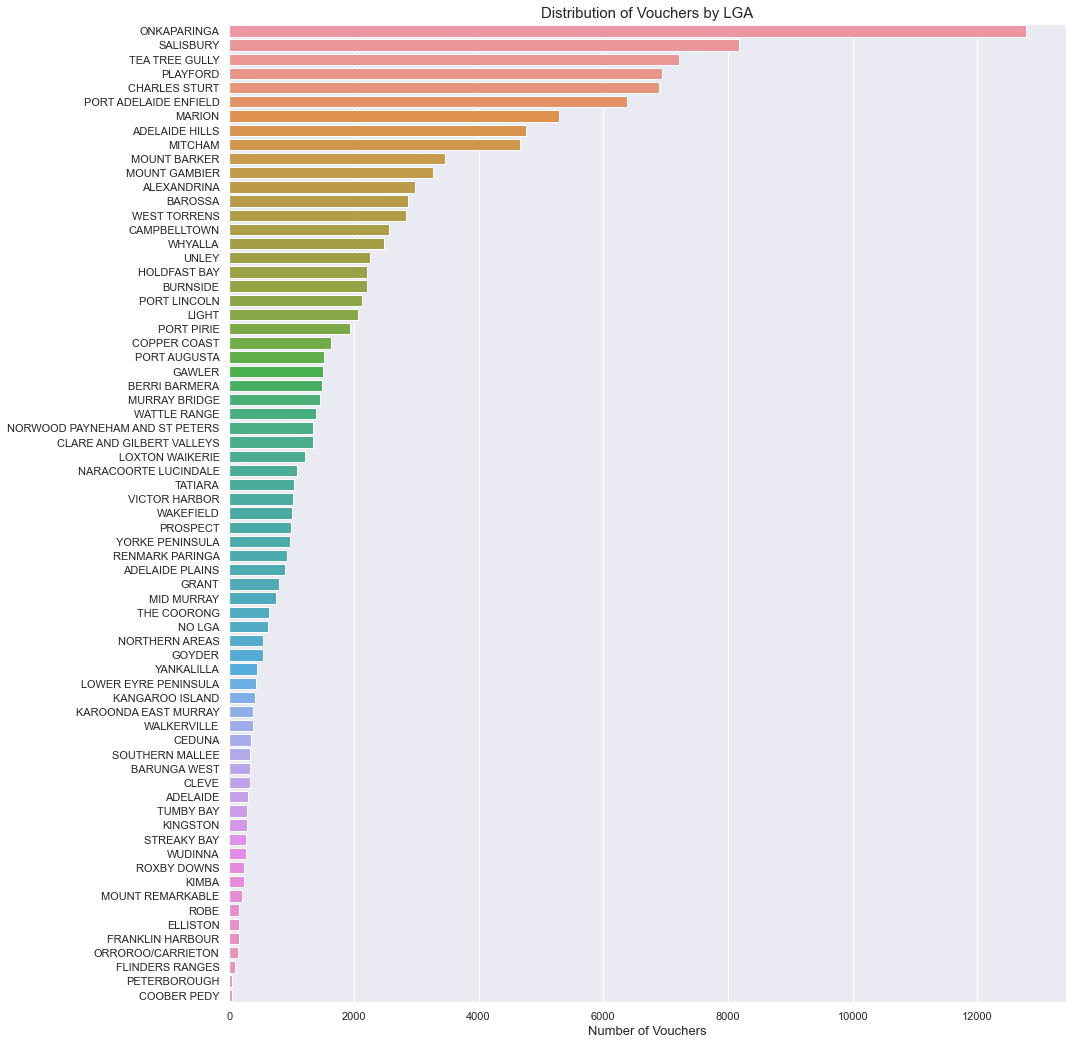

In [24]:
# show distribution of vouchers by LGA
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15, 18))
LGA_vouchers = LGA_vouchers.sort_values("Voucher_Count", ascending = False)
sns.barplot(data=LGA_vouchers, x="Voucher_Count", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [25]:
LGA_vouchers["Voucher_prop"] = round(LGA_vouchers["Voucher_Count"] / sum(LGA_vouchers["Voucher_Count"]) * 100, 2)
LGA_vouchers = LGA_vouchers.sort_values(by="Voucher_prop", ascending = False)
print("Proportion of number of vouchers for top 15 LGAs:\t", LGA_vouchers["Voucher_prop"].nlargest(15).sum())
print("Total number of LGAs:\t", LGA_vouchers.shape[0])

Proportion of number of vouchers for top 15 LGAs:	 63.599999999999994
Total number of LGAs:	 69


## Findings of LGA analysis:
It can clearly be seen that there is a highly uneven distribution between different areas. There are 69 LGAs in the dataset but only 15 of those account for around 64% of vouchers that have been redeemed throughout the state.

## By Sports

In [26]:
# group by sports
sports_vouchers = sa_vouchers_scores.groupby(
    "Voucher_Sport")["Voucher_Sport"].count().to_frame(name = 'Voucher_Count').reset_index()
sports_vouchers = sports_vouchers.sort_values(by='Voucher_Count', ascending= False)
sports_vouchers.head(10)

,Voucher_Sport,Voucher_Count
2,Australian Rules,47224
27,Netball,24017
15,Football (Soccer),15775
17,Gymnastics,9823
6,Basketball,6016
1,Athletics,4518
44,Tennis,3742
18,Hockey,3026
8,Calisthenics,2522
9,Cricket,1875


In [27]:
# calculate proportion of vouchers per sport, then show where 80% of vouchers are redeemed
sports_vouchers["Voucher_prop"] = round(sports_vouchers["Voucher_Count"]/sum(sports_vouchers["Voucher_Count"])*100, 2)
sports_vouchers.head(10)
    

,Voucher_Sport,Voucher_Count,Voucher_prop
2,Australian Rules,47224,37.03
27,Netball,24017,18.83
15,Football (Soccer),15775,12.37
17,Gymnastics,9823,7.70
6,Basketball,6016,4.72
1,Athletics,4518,3.54
44,Tennis,3742,2.93
18,Hockey,3026,2.37
8,Calisthenics,2522,1.98
9,Cricket,1875,1.47


In [28]:
sports_vouchers["Voucher_prop"].head(10).sum(), sports_vouchers.shape

(92.94000000000001, (50, 3))

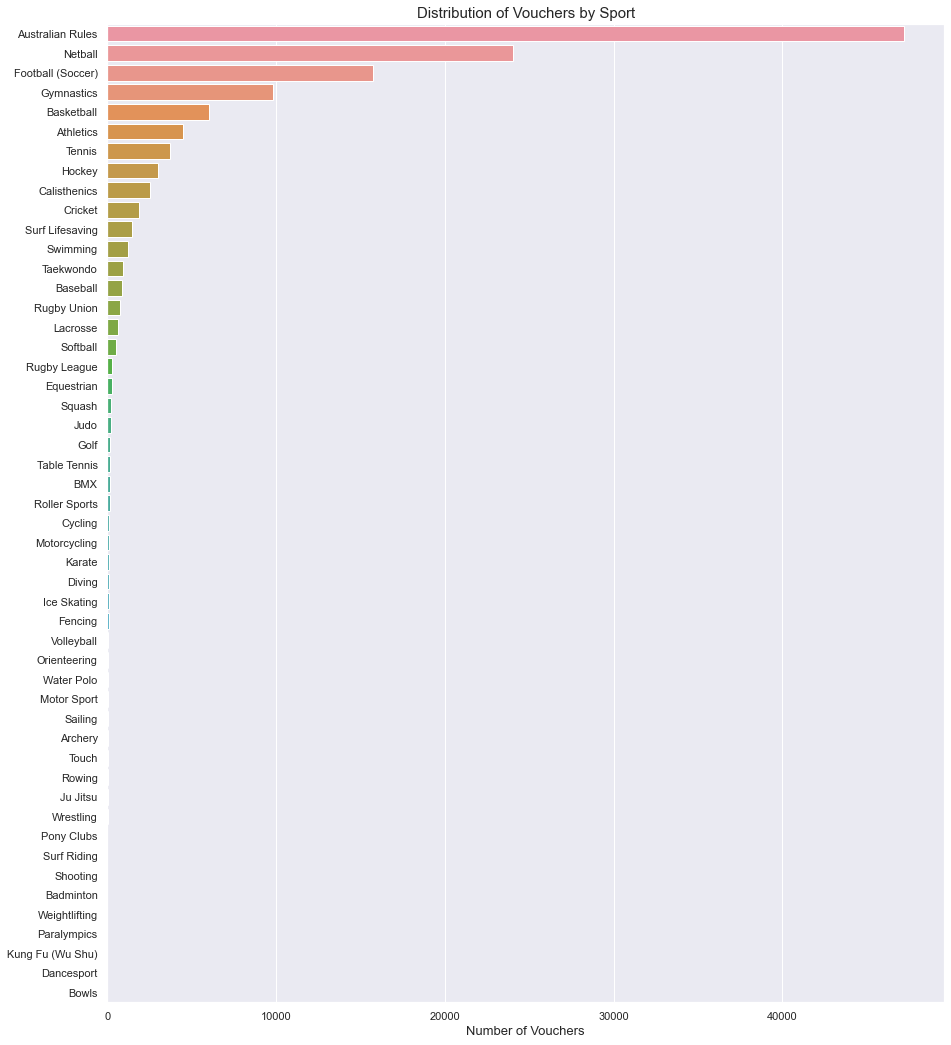

In [29]:
# show distribution of vouchers by sports
plt.figure(figsize=(15, 18))
sns.barplot(data=sports_vouchers, x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

In [30]:
# show sports where less than 50 vouchers have been redeemed
sports_vouchers[sports_vouchers["Voucher_Count"] < 50]

,Voucher_Sport,Voucher_Count,Voucher_prop
47,Water Polo,48,0.04
25,Motor Sport,45,0.04
35,Sailing,40,0.03
0,Archery,34,0.03
45,Touch,23,0.02
32,Rowing,22,0.02
20,Ju Jitsu,22,0.02
49,Wrestling,19,0.01
30,Pony Clubs,17,0.01
40,Surf Riding,15,0.01


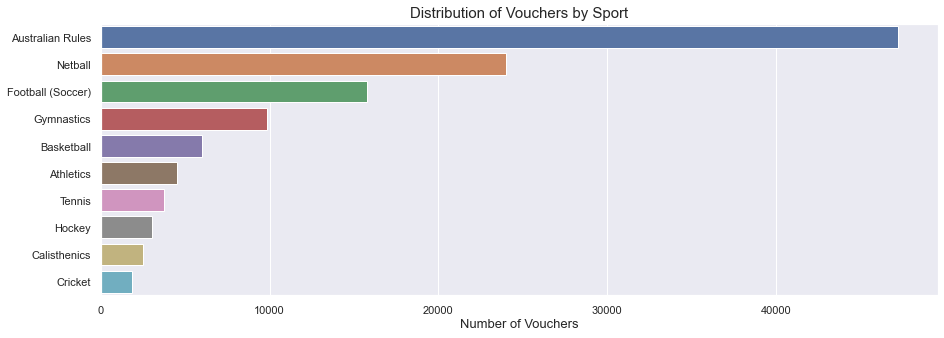

In [31]:
# show distribution of vouchers by more relevant sports
plt.figure(figsize=(15, 5))
sns.barplot(data=sports_vouchers.nlargest(10, "Voucher_Count"), x="Voucher_Count", y="Voucher_Sport")
plt.title("Distribution of Vouchers by Sport", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

## Findings of Sports analysis:

It can clearly be seen that the distribution of voucher redemption by sports is highly uneven. There are 50 sports to choose from, however, 10 of these account for over 90% of vouchers.

# Are some sports more popular in different parts of the state?

In [32]:
# select 10 most popular sports and 15 most populated states
LGA_top15 = LGA_vouchers.nlargest(15, "Voucher_Count")
sports_top10 = sports_vouchers.nlargest(10, "Voucher_Count")
sports_top10

,Voucher_Sport,Voucher_Count,Voucher_prop
2,Australian Rules,47224,37.03
27,Netball,24017,18.83
15,Football (Soccer),15775,12.37
17,Gymnastics,9823,7.70
6,Basketball,6016,4.72
1,Athletics,4518,3.54
44,Tennis,3742,2.93
18,Hockey,3026,2.37
8,Calisthenics,2522,1.98
9,Cricket,1875,1.47


In [33]:
# create list with popular sport
sports_list = sports_top10["Voucher_Sport"].tolist()
sports_list

['Australian Rules',
 'Netball',
 'Football (Soccer)',
 'Gymnastics',
 'Basketball',
 'Athletics',
 'Tennis',
 'Hockey',
 'Calisthenics',
 'Cricket']

In [34]:
# group by participants LGA and sports
LGA_sports_vouchers = sa_vouchers_scores.groupby(
    ["Participant_LGA", "Voucher_Sport"])["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
LGA_sports_vouchers

,Participant_LGA,Voucher_Sport,Voucher_Count
0,ADELAIDE,Athletics,16
1,ADELAIDE,Australian Rules,130
2,ADELAIDE,Baseball,1
3,ADELAIDE,Basketball,4
4,ADELAIDE,Calisthenics,1
...,...,...,...
1152,YORKE PENINSULA,Motorcycling,2
1153,YORKE PENINSULA,Netball,313
1154,YORKE PENINSULA,Surf Lifesaving,4
1155,YORKE PENINSULA,Taekwondo,87


In [35]:
# drop records that are not in list with most popular sport
LGA_sports_clean = LGA_sports_vouchers[LGA_sports_vouchers["Voucher_Sport"].isin(sports_list)]
LGA_sports_clean

,Participant_LGA,Voucher_Sport,Voucher_Count
0,ADELAIDE,Athletics,16
1,ADELAIDE,Australian Rules,130
3,ADELAIDE,Basketball,4
4,ADELAIDE,Calisthenics,1
5,ADELAIDE,Cricket,2
...,...,...,...
1147,YORKE PENINSULA,Football (Soccer),7
1149,YORKE PENINSULA,Gymnastics,1
1150,YORKE PENINSULA,Hockey,99
1153,YORKE PENINSULA,Netball,313


In [36]:
# reshape grouped output
LGA_sports_piv = pd.pivot_table(LGA_sports_clean, index="Participant_LGA", columns="Voucher_Sport", values="Voucher_Count")
LGA_sports_piv

Voucher_Sport,Athletics,Australian Rules,Basketball,Calisthenics,Cricket,Football (Soccer),Gymnastics,Hockey,Netball,Tennis
Participant_LGA,,,,,,,,,,
ADELAIDE,16.0,130.0,4.0,1.0,2.0,27.0,20.0,17.0,23.0,4.0
ADELAIDE HILLS,204.0,1412.0,48.0,62.0,128.0,812.0,176.0,52.0,1395.0,257.0
ADELAIDE PLAINS,3.0,485.0,15.0,23.0,3.0,93.0,18.0,16.0,160.0,13.0
ALEXANDRINA,62.0,980.0,204.0,5.0,8.0,510.0,86.0,39.0,860.0,109.0
BAROSSA,158.0,1196.0,341.0,9.0,56.0,197.0,117.0,213.0,445.0,83.0
...,...,...,...,...,...,...,...,...,...,...
WEST TORRENS,114.0,907.0,70.0,45.0,85.0,425.0,386.0,49.0,268.0,158.0
WHYALLA,15.0,569.0,605.0,15.0,12.0,268.0,154.0,321.0,509.0,NaN
WUDINNA,29.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,194.0,NaN


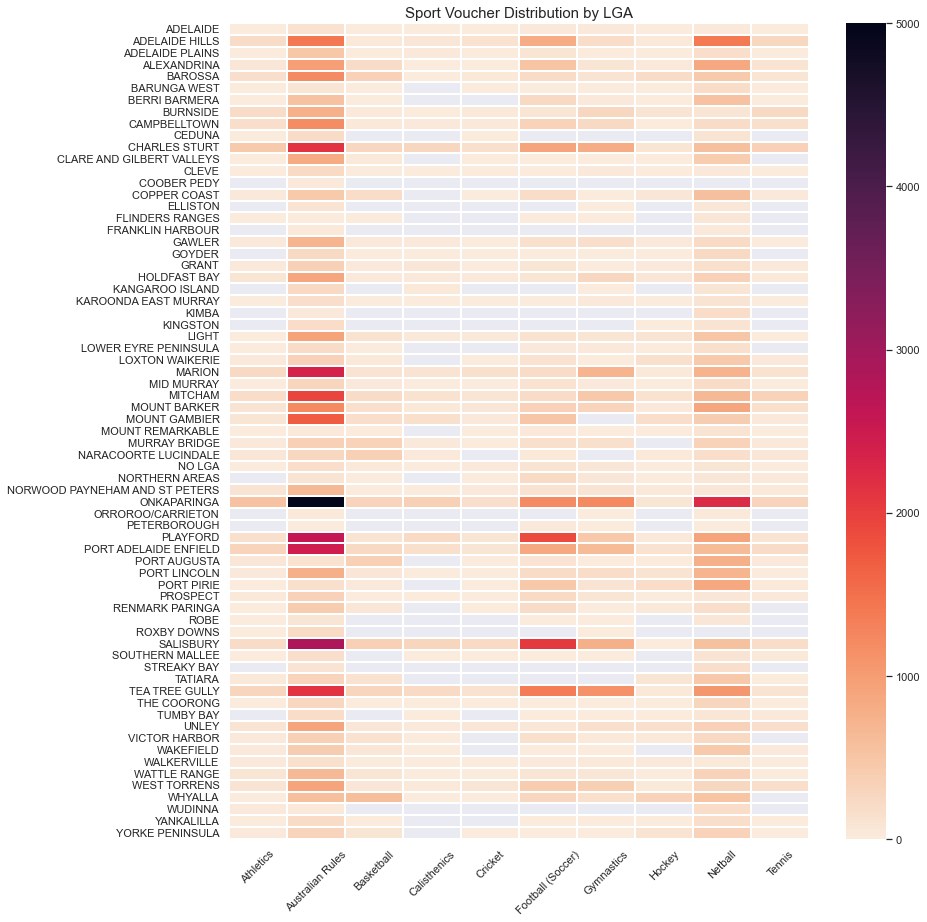

In [37]:
plt.figure(figsize=(13, 15))
sns.heatmap(LGA_sports_piv, vmin=0, vmax=5000, cmap=sns.cm.rocket_r, linewidths=0.1)
plt.title("Sport Voucher Distribution by LGA", fontsize = 15)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=45);

There a few things to note about this heatmap:
1. Since all LGAs are included, there are a lot of empty values. Thus, it can be seen in which areas more or less vouchers are redeemed. In the following, another heatmap will be shown to get a more granular view between states that have higher voucher redemption. Actually, as it has been shown, this is due to population size and the hypothesis whether there is a difference between rural and metropolitan areas will be tested later with plotting a map.
2. The popluarity of sports is visualised on the map. The more popular a sport is, the less missing values it has across LGAs. It can be seen that vouchers for Australian Rules are redeemed in every single area, while Netball vouchers are redeemed in almost every area. This underlines their popularity throughout the state.

In [38]:
# create list with 15 most populated areas
LGA_list = LGA_top15["Participant_LGA"].tolist()
LGA_list

['ONKAPARINGA',
 'SALISBURY',
 'TEA TREE GULLY',
 'PLAYFORD',
 'CHARLES STURT',
 'PORT ADELAIDE ENFIELD',
 'MARION',
 'ADELAIDE HILLS',
 'MITCHAM',
 'MOUNT BARKER',
 'MOUNT GAMBIER',
 'ALEXANDRINA',
 'BAROSSA',
 'WEST TORRENS',
 'CAMPBELLTOWN']

In [39]:
# drop records from grouped df that are not in list with most populated areas
LGA_sports_clean2 = LGA_sports_clean[LGA_sports_clean["Participant_LGA"].isin(LGA_list)]
LGA_sports_clean2

,Participant_LGA,Voucher_Sport,Voucher_Count
22,ADELAIDE HILLS,Athletics,204
23,ADELAIDE HILLS,Australian Rules,1412
26,ADELAIDE HILLS,Basketball,48
27,ADELAIDE HILLS,Calisthenics,62
28,ADELAIDE HILLS,Cricket,128
...,...,...,...
1092,WEST TORRENS,Football (Soccer),425
1094,WEST TORRENS,Gymnastics,386
1095,WEST TORRENS,Hockey,49
1098,WEST TORRENS,Netball,268


In [40]:
# reshape grouped output
LGA_sports_piv2 = pd.pivot_table(LGA_sports_clean2, 
                                 index="Voucher_Sport", 
                                 columns="Participant_LGA", 
                                 values="Voucher_Count")
LGA_sports_piv2

Participant_LGA,ADELAIDE HILLS,ALEXANDRINA,BAROSSA,CAMPBELLTOWN,CHARLES STURT,MARION,MITCHAM,MOUNT BARKER,MOUNT GAMBIER,ONKAPARINGA,PLAYFORD,PORT ADELAIDE ENFIELD,SALISBURY,TEA TREE GULLY,WEST TORRENS
Voucher_Sport,,,,,,,,,,,,,,,
Athletics,204.0,62.0,158.0,162.0,447.0,238.0,176.0,107.0,86.0,541.0,147.0,298.0,214.0,280.0,114.0
Australian Rules,1412.0,980.0,1196.0,1186.0,2147.0,2362.0,1939.0,1230.0,1710.0,5258.0,2580.0,2453.0,2856.0,2131.0,907.0
Basketball,48.0,204.0,341.0,40.0,256.0,101.0,210.0,147.0,168.0,296.0,111.0,243.0,362.0,284.0,70.0
Calisthenics,62.0,5.0,9.0,26.0,266.0,104.0,125.0,47.0,155.0,353.0,216.0,150.0,282.0,231.0,45.0
Cricket,128.0,8.0,56.0,47.0,137.0,155.0,89.0,65.0,22.0,168.0,91.0,90.0,220.0,118.0,85.0
Football (Soccer),812.0,510.0,197.0,319.0,917.0,203.0,198.0,333.0,502.0,1204.0,1880.0,853.0,2069.0,1356.0,425.0
Gymnastics,176.0,86.0,117.0,248.0,807.0,719.0,457.0,294.0,NaN,1211.0,451.0,627.0,763.0,1114.0,386.0
Hockey,52.0,39.0,213.0,17.0,87.0,57.0,123.0,36.0,164.0,82.0,34.0,124.0,17.0,42.0,49.0
Netball,1395.0,860.0,445.0,205.0,584.0,723.0,658.0,880.0,393.0,2242.0,904.0,630.0,566.0,1068.0,268.0


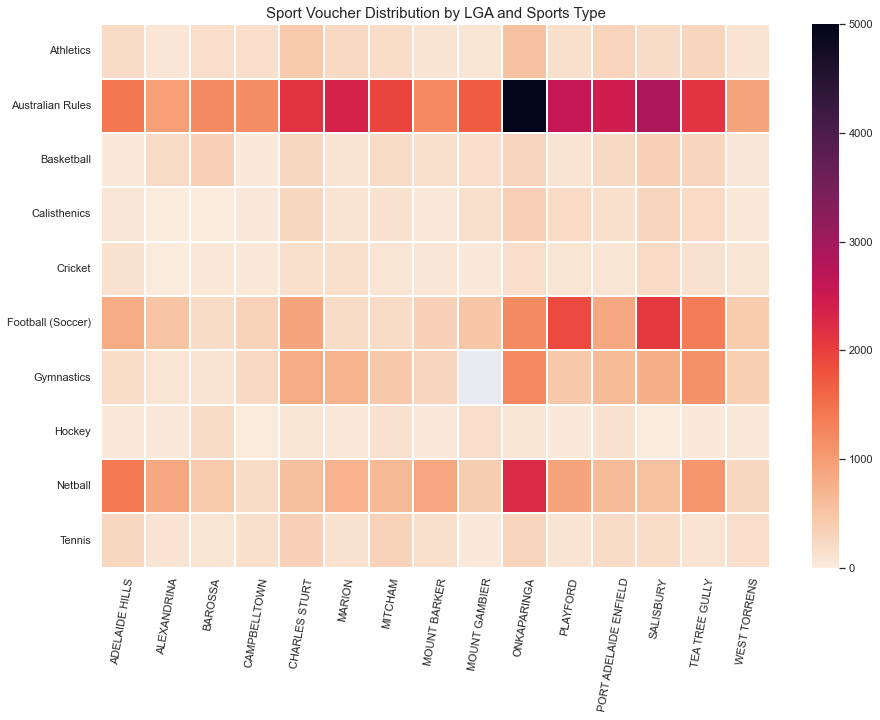

In [41]:
# create heatmap with most populated areas
plt.figure(figsize=(15, 10))
sns.heatmap(LGA_sports_piv2, vmin=0, vmax=5000, cmap=sns.cm.rocket_r, linewidth=0.1)
plt.title("Sport Voucher Distribution by LGA and Sports Type", fontsize = 15)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=80);

## Findings:
It can clearly be seen that Australian Rules is by far the most popular sport across all states. Even in the top 15 LGAs, this sport still stands out. It is also clear that it is especially popular in Onkaparinga.

## Plot Voucher distribution on Map

In [42]:
map_df.head()

,lgatype,abbname,lga,shape_Length,shape_Area,geometry,Participant_ID,Participant_Suburb,Club_Previous_Member,Participant_ATSI_Indicator,...,Voucher_Sport,Participant_LGA,Participant_Electorate,Voucher_Completion_Date,Voucher_Claim_Year,IEO,IER,IRSAD,IRSD,Population
0,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000830.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Football (Soccer),ADELAIDE,ADELAIDE,29/5/15 0:01,2015.0,874.0,874.0,1036.0,1013.0,19606.0
1,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000831.0,ADELAIDE,Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/12/15 3:31,2015.0,874.0,874.0,1036.0,1013.0,19606.0
2,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,7/6/16 3:12,2016.0,874.0,874.0,1036.0,1013.0,19606.0
3,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000833.0,ADELAIDE,Registered Previously,Not ATSI,...,Australian Rules,ADELAIDE,ADELAIDE,9/11/15 2:24,2015.0,874.0,874.0,1036.0,1013.0,19606.0
4,CC,ADELAIDE,ADELAIDE CITY COUNCIL,0.154856,0.001506,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",1000834.0,ADELAIDE,Not Registered Previously,Not ATSI,...,Athletics,ADELAIDE,ADELAIDE,29/11/16 6:50,2016.0,874.0,874.0,1036.0,1013.0,19606.0


In [43]:
# join relevant columns with count aggregate
voucher_count = sa_vouchers_scores.groupby(
    "Participant_LGA")["Participant_LGA"].count().to_frame(name = 'Voucher_Count').reset_index()
plot_count = map_df[['abbname', 'geometry']]
plot = pd.merge(plot_count, voucher_count, how='left', left_on = 'abbname', right_on = 'Participant_LGA')
plot = plot.drop("Participant_LGA", axis=1)
plot

,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
1,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
2,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
3,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
4,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
...,...,...,...
126902,WAKEFIELD,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297...",1010.0
126903,WAKEFIELD,"MULTIPOLYGON (((138.49757 -33.62578, 138.50297...",1010.0
126904,UIA RIVERLAND,"MULTIPOLYGON (((140.72829 -34.10345, 140.72841...",NaN
126905,MT,"MULTIPOLYGON (((132.99386 -28.11736, 132.99888...",NaN


In [80]:
# keep distinct records and fill nan with 0
plot_distinct = plot.drop_duplicates()
plot_distinct = plot_distinct.dropna()
plot_distinct

,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
302,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0
2515,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0
5786,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0
12170,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0
...,...,...,...
114135,ROXBY DOWNS,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787...",234.0
114369,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
121588,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0
124432,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0


In [84]:
plot_distinct[(plot_distinct['abbname']=='ROXBY DOWNS') | (plot_distinct['abbname']=='COOBER PEDY')]

,abbname,geometry,Voucher_Count
55230,COOBER PEDY,"MULTIPOLYGON (((134.80915 -29.05169, 134.80757...",39.0
114135,ROXBY DOWNS,"MULTIPOLYGON (((136.89787 -30.48077, 136.89787...",234.0


In [90]:
plot_distinct = plot_distinct.drop((
    plot_distinct[plot_distinct['abbname']=='ROXBY DOWNS'].index) | 
    (plot_distinct[plot_distinct['abbname']=='COOBER PEDY'].index))
plot_distinct

/var/folders/31/2xxsfpps75923jkzs3xks1w00000gq/T/ipykernel_65309/4158204712.py:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  plot_distinct = plot_distinct.drop((


,abbname,geometry,Voucher_Count
0,ADELAIDE,"MULTIPOLYGON (((138.61916 -34.92526, 138.62178...",302.0
302,BURNSIDE,"MULTIPOLYGON (((138.69662 -34.92009, 138.69746...",2213.0
2515,MOUNT GAMBIER,"MULTIPOLYGON (((140.78651 -37.80198, 140.78662...",3271.0
5786,PORT ADELAIDE ENFIELD,"MULTIPOLYGON (((138.51045 -34.79261, 138.50967...",6384.0
12170,PORT AUGUSTA,"MULTIPOLYGON (((137.75403 -32.37753, 137.75448...",1522.0
...,...,...,...
112200,PORT PIRIE,"MULTIPOLYGON (((138.16422 -33.10628, 138.16488...",1935.0
114369,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
121588,WEST TORRENS,"MULTIPOLYGON (((138.57680 -34.90910, 138.57685...",2844.0
124432,MURRAY BRIDGE,"MULTIPOLYGON (((139.01938 -34.95261, 139.02040...",1462.0


Note: the three LGAs with 0 vouchers have been removed since they distort the visualisation of the map. These are all in the north of the state and do not add information, but rather occupy half of the map which leads to relevant states being too small and not distinguishable. Roxby Downs and Coober Pedy are removed too because they are in between the other three that do not add information. Even though there are vouchers redeemed, the number is insignificantly small.

In [100]:
top5 = plot_distinct.sort_values("Voucher_Count", ascending=False).nlargest(5, "Voucher_Count")
top5

,abbname,geometry,Voucher_Count
92478,ONKAPARINGA,"MULTIPOLYGON (((138.56395 -35.02975, 138.56397...",12782.0
24033,SALISBURY,"MULTIPOLYGON (((138.65927 -34.72560, 138.65598...",8169.0
114369,TEA TREE GULLY,"MULTIPOLYGON (((138.77559 -34.73521, 138.77396...",7219.0
105260,PLAYFORD,"MULTIPOLYGON (((138.67086 -34.61590, 138.67110...",6940.0
75324,CHARLES STURT,"MULTIPOLYGON (((138.47942 -34.85039, 138.48376...",6897.0


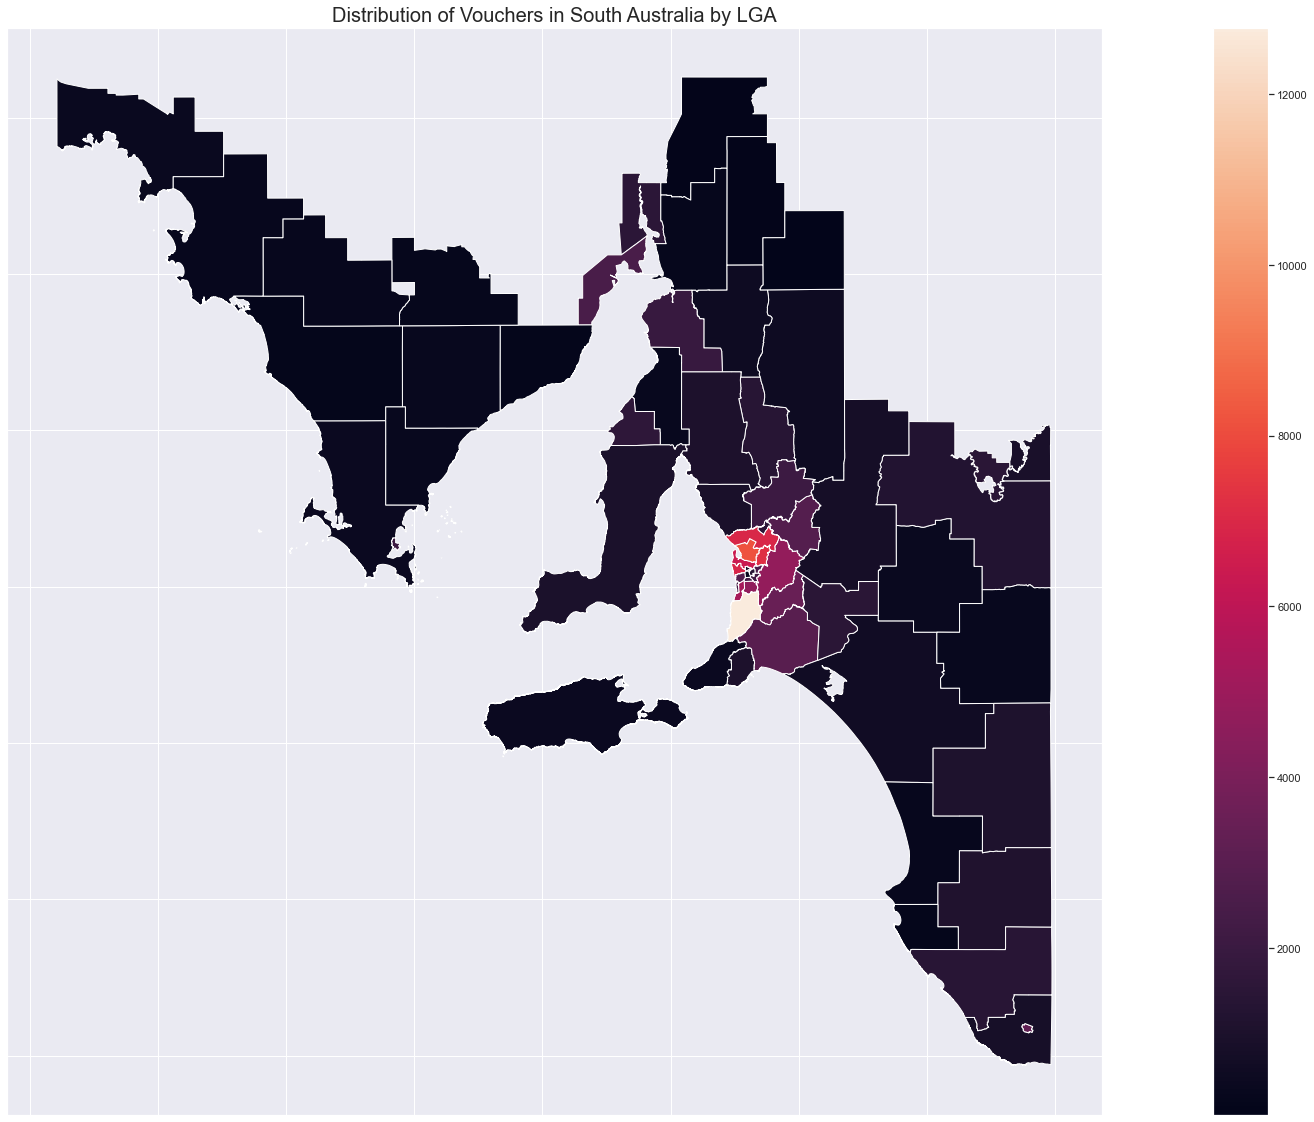

In [96]:
# plot voucher count on map
plt.rcParams["figure.figsize"] = (40, 20)
plot_distinct.plot(column='Voucher_Count', legend=True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.title("Distribution of Vouchers in South Australia by LGA", fontsize=20);

As expected, the LGAs with most number of vouchers are found in the metropolitan area around Adelaide.

# Are any LGAs over/under represented in their use of vouchers?

# calculate mean value of voucher amount and subtract from value to show over/under
# double check missing values

In [46]:
# extract LGAs and respective population from main dataframe
population = sa_vouchers_scores.drop_duplicates("Participant_LGA")[["Participant_LGA", "Population"]]
population.sort_values(by='Participant_LGA')

,Participant_LGA,Population
829,ADELAIDE,19606.0
1275,ADELAIDE HILLS,38601.0
6954,ADELAIDE PLAINS,NaN
4122,ALEXANDRINA,23693.0
3093,BAROSSA,22174.0
...,...,...
5287,WEST TORRENS,54932.0
71759,WHYALLA,22070.0
51891,WUDINNA,1256.0
6436,YANKALILLA,4406.0


In [47]:
# check for missing values 
population[population["Population"].isnull()]

,Participant_LGA,Population
2775,NO LGA,NaN
3077,LIGHT,NaN
6954,ADELAIDE PLAINS,NaN
6978,BERRI BARMERA,NaN
8952,NARACOORTE LUCINDALE,NaN
12924,PORT PIRIE,NaN
17731,NORWOOD PAYNEHAM AND ST PETERS,NaN


Missing values will be read in from the 2016 census data manually. In the original government data, there is a record for 'unincorporated' LGA which is explained as communities that do not belong to any LGA. Thus, it is assumed that 'NO LGA' reflects this category since 'unincorporated' cannot be found in the dataframe.

In [48]:
# fill in missing values by looking up population amount
fill = pd.DataFrame(index = population.index[population.isnull().any(axis=1)],
                    data= [3583, 15041, 8912, 10838, 8544, 17767, 36396],
                    columns=[1])
population = population.fillna(fill)
population.isnull().any()

Participant_LGA    False
Population          True
dtype: bool

In [49]:
df_nan = pd.DataFrame(data=[['NO LGA', 3583], ['LIGHT', 15041], ['ADELAIDE PLAINS', 8912], ['BERRI BARMERA', 10838], ['NARACOORTE LUCINDALE', 8544], ['PORT PIRIE', 17767], ['NORWOOD PAYNEHAM AND ST PETERS', 36396]], 
                     columns=['Participant_LGA', 'Population'])
df_nan

,Participant_LGA,Population
0,NO LGA,3583
1,LIGHT,15041
2,ADELAIDE PLAINS,8912
3,BERRI BARMERA,10838
4,NARACOORTE LUCINDALE,8544
5,PORT PIRIE,17767
6,NORWOOD PAYNEHAM AND ST PETERS,36396


In [50]:
# check spelling berri and barmera
sa_vouchers[sa_vouchers['Participant_LGA'].str.contains('berri', case=False)].

SyntaxError: invalid syntax (2503617266.py, line 2)

In [ ]:
# Concatenate to single dataframe
LGA_vouchers.sort_values(by='Participant_LGA')
pop_lga = pd.merge(population, LGA_vouchers, 'outer', 'Participant_LGA')
pop_lga

In [ ]:
pop_lga[pop_lga["Participant_LGA"] == "ADELAIDE PLAINS"]

In [ ]:
# show correlation between population and number of vouchers
pop_lga.corr()

Since there is a high correlation, this indicates that the number of vouchers per area should be considered relatively to population size for comparison. <br >
__Note:__ In the pop_lga dataframe it can be seen that there is a LGA with population size zero but 899 vouchers redeemed. Since this should not be the case, further analysis in this regard will be done in the following before showing the distribution of number of vouchers per LGA relative to population size.

In [ ]:
# check spelling of these LGAs in census data
seifa[seifa["LGA"].str.contains('ADELAIDE PLAINS') == True]

In [ ]:
# check spelling of these LGAs in voucher data
sa_vouchers[sa_vouchers["Participant_LGA"].str.contains('ADELAIDE PLAINS') == True]

In [ ]:
# remove records where values for population are missing
pop_lga_clean = pop_lga.dropna()
pop_lga_clean

In [ ]:
# create column of number of vouchers per thousand people in each LGA
pop_lga_clean["Voucher_Per_100"] = round(
    (pop_lga_clean["Voucher_Count"] / pop_lga_clean["Population"]) * 100, 2)
pop_lga_clean = pop_lga_clean.sort_values("Voucher_Per_100", ascending = False)
pop_lga_clean

In [ ]:
plt.figure(figsize=(15, 18))
sns.barplot(data=pop_lga_clean, x="Voucher_Per_100", y="Participant_LGA")
plt.title("Distribution of Vouchers by LGA per 100 people", fontsize=15)
plt.xlabel("Number of Vouchers", fontsize = 13)
plt.ylabel("");

## Findings of LGA analysis:

For this analysis, the few LGAs where no seifa data has been collected, have been omitted. For the remaining LGAs it can be seen that, first, the distribution of redeemed vouchers has changed by a lot and, second, the distribution is more even than without taking population size into consideration.<br >
For example, in Karoonda East Murray, only 388 vouchers were redeemed which puts them at the lower end of number of number of vouchers per LGA. However, after considering population size, it becomes clear that out of 100 people in this LGA, around 38 redeem sports vouchers. Through this analysis it has been shown where sports vouchers are more or less popular.

# Is there a relationship between any of the SEIFA measures and voucher use in an LGA?

1. conduct univariate analysis of variables
2. conduct bivariate analysis of variables with target variable
3. catogorise into low, mid, high socioeconomic area
4. transform categorical variables into binary format

In [ ]:
sa_vouchers_scores

## Conduct univariate analysis of variables

## ATSI

## CALD

## Sex

## IEO

## IER

## IRSAD

## IRSD

# Challenge - Queensland

_Note: this is an extra task that you might take on to get a better grade for your portfolio.  You can get a good pass grade without doing this._ 

Queensland has a similar program called [Get Started](https://data.gov.au/dataset/ds-qld-3118838a-d425-48fa-bfc9-bc615ddae44e/details?q=get%20started%20vouchers) and we can retrieve data from their program in a similar format.  

The file [round1-redeemed_get_started_vouchers.csv](files/round1-redeemed_get_started_vouchers.csv) contains records of the vouchers issued in Queensland. The date of this data is not included but the program started in 2015 so it is probably from around then.  

The data includes the LGA of the individual but the name of the activity is slightly different.  To do a comparable analysis you would need to map the activity names onto those from South Australia. 

In [ ]:
qld_vouchers = pd.read_csv('files/round1-redeemed_get_started_vouchers.csv')
qld_vouchers.head()

In [ ]:
# Join the QLD data with the LGA data as before to get population and SIEFA data integrated
qld_vouchers['LGA'] = qld_vouchers['Club Local Government Area Name'].str.replace(' \([RC]+\)', '').str.upper()
qld_vouchers_scores = qld_vouchers.join(LGA_scores, on='LGA')
qld_vouchers_scores.head()